In [1]:
!gdown "1ur4CrYKZT197pOCdZCSt-7DabXbcp-x_"

Downloading...
From: https://drive.google.com/uc?id=1ur4CrYKZT197pOCdZCSt-7DabXbcp-x_
To: /content/kaggle.json
100% 63.0/63.0 [00:00<00:00, 265kB/s]


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d rizkyyk/word2vec-400dim
!kaggle datasets download -d rizkyyk/fastext-model-tweet

Dataset URL: https://www.kaggle.com/datasets/rizkyyk/word2vec-400dim
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 164M/166M [00:10<00:00, 18.6MB/s]
100% 166M/166M [00:10<00:00, 17.1MB/s]
Dataset URL: https://www.kaggle.com/datasets/rizkyyk/fastext-model-tweet
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 764M/765M [00:39<00:00, 20.7MB/s]
100% 765M/765M [00:39<00:00, 20.1MB/s]


In [4]:
!unzip fastext-model-tweet.zip -d /content/dataset
!unzip word2vec-400dim.zip -d /content/dataset

Archive:  fastext-model-tweet.zip
  inflating: /content/dataset/Fastext_model_tweet.bin  
Archive:  word2vec-400dim.zip
  inflating: /content/dataset/Word2Vec_400dim.txt  


In [5]:
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 3.9 MB/s eta 0:00:00


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv
import numpy as np
import seaborn as sns
from time import time
import gensim
import nltk

from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
file_loc = "https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/Twitter_Emotion_Dataset.csv"
dataset = pd.read_csv(file_loc, lineterminator="\n")
dataset

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m..."
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ..."
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...


In [9]:
# Melihat nilai unik dari kolom 'label'
unique_values = dataset['label'].unique()

print(unique_values)

['anger' 'happy' 'sadness' 'love' 'fear']


In [10]:
# Mendefinisikan mapping dari emosi ke sentimen
emotion_to_sentiment = {
    'happy': 'positive',
    'love': 'positive',
    'anger': 'negative',
    'sadness': 'negative',
    'fear': 'negative'
}
# Mengubah label emosi menjadi label sentimen
dataset['sentiment'] = dataset['label'].map(emotion_to_sentiment)
dataset

,label,tweet,sentiment
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",negative
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",positive
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",positive
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,negative
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",negative
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,positive


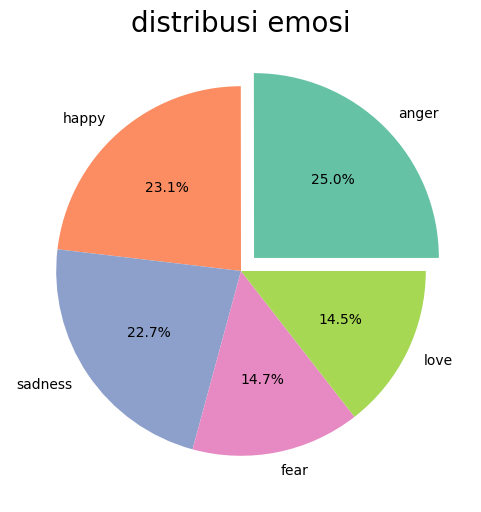

In [11]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in dataset['label'].value_counts()]
labels = list(dataset['label'].value_counts().index)
explode = (0.1, 0, 0, 0, 0)  # Offset the first segment
# Gunakan palet warna Seaborn
colors = sns.color_palette('Set2')
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, textprops={'fontsize': 10})
ax.set_title('distribusi emosi', fontsize = 20)
plt.show()

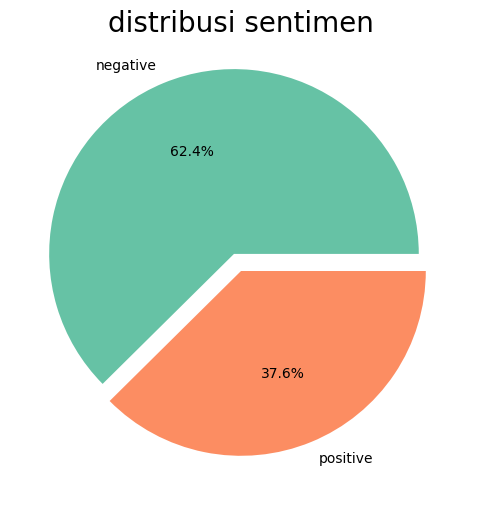

In [12]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in dataset['sentiment'].value_counts()]
labels = list(dataset['sentiment'].value_counts().index)
# Jumlah label
num_labels = len(labels)

# Buat tuple explode dengan semua nilai 0, kecuali untuk label pertama
explode = (0.1,) + (0,) * (num_labels - 1)

# Plot pie chart
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, textprops={'fontsize': 10})

# Gunakan palet warna Seaborn
colors = sns.color_palette('Set2')

ax.set_title('distribusi sentimen', fontsize = 20)
plt.show()

In [13]:
stopword_bahasa = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/stopwordbahasa.csv', encoding='latin-1')
stopword_bahasa = stopword_bahasa.rename(columns={0: 'stop'})
stopword_bahasa.head()

,ada
0,adalah
1,adanya
2,adapun
3,agak
4,agaknya


In [14]:
kamus_alay = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/kamus_alay.csv', header=None, encoding='latin-1')
kamus_alay = kamus_alay.rename(columns={0: 'original',
                                     1: 'replacement'})
kamus_alay_map = dict(zip(kamus_alay['original'], kamus_alay['replacement']))
kamus_alay.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [15]:
kamus_singkatan = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/kamus_singkatan.csv', sep=';', encoding='latin-1')
kamus_singkatan.columns = ['Column1', 'Column2']
kamus_singkatan = kamus_singkatan.rename(columns={'Column1': 'original', 'Column2': 'replacement'})
kamus_singkatan_map = dict(zip(kamus_singkatan['original'], kamus_singkatan['replacement']))
kamus_singkatan.head()

,original,replacement
0,adek,adik
1,adlh,adalah
2,aer,air
3,aiskrim,es krim
4,aj,saja


## Cleaning

In [16]:
def lowercase(text):
    return text.lower()
dataset["cleaning"] = dataset.tweet.apply(lambda text: lowercase(text))
dataset.head(3)

,label,tweet,sentiment,cleaning
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative,"soal jln jatibaru,polisi tdk bs gertak gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative,"sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive,kepingin gudeg mbarek bu hj. amad foto dari go...


In [17]:
def remove_unnecessary_char(text):
    text = re.sub('\n', ' ', text) # Remove every newline character
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Remove every username
    text = re.sub('user', ' ', text) # Remove every occurrence of the word 'user'
    text = re.sub('rt', ' ', text) # Remove every retweet symbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Remove every URL
    text = re.sub('https?://t\.me/[^\s]+', ' ', text) # Remove every Telegram link
    text = re.sub ('[^0-9a-zA-Z]+', ' ', text) # Remove every non-alphanumeric character
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
dataset["cleaning"] = dataset.cleaning.apply(lambda text: remove_unnecessary_char(text))
dataset.head(3)

,label,tweet,sentiment,cleaning
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative,soal jln jatibaru polisi tdk bs ge ak gubernur...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative,sesama cewe lho kayaknya harusnya bisa lebih r...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive,kepingin gudeg mbarek bu hj amad foto dari goo...


## Preprocessing

In [18]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Text preprocessing functions from previous script
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text
def transform_emoticons(text):
    text = text.replace("<3", "<love>")
    text = text.replace(":p", "<mengejek>")
    text = text.replace(":P", "<mengejek>")
    text = text.replace(":v", "<melucu>")
    text = text.replace(":V", "<melucu>")
    text = text.replace(":d", "<tertawa>")
    text = text.replace(":D", "<tertawa>")
    text = text.replace(":-D", "<tertawa>")
    text = text.replace(":o", "<terkejut>")
    text = text.replace(":O", "<terkejut>")
    text = text.replace("xD", "<tertawa terbahak bahak>")
    text = text.replace("XD", "<tertawa terbahak bahak>")
    text = text.replace(":*", "<mencium>")
    text = text.replace(":3", "<malu malu kucing>")
    text = text.replace("-__-", "<wajah datar>")
    text = text.replace("-_-", "<wajah datar>")
    text = text.replace(":|", "<wajah datar>")
    text = text.replace(":\\", "<terganggu>")
    text = text.replace(":/", "<terganggu>")
    text = text.replace(":))", "<senyum>")
    text = text.replace(":)", "<senyum>")
    text = text.replace(":-))", "<senyum>")
    text = text.replace(":-)", "<senyum>")
    text = text.replace("^^", "<senyum>")
    text = text.replace("^_^", "<senyum>")
    text = text.replace(";))", "<senyum berkedip>")
    text = text.replace(";)", "<senyum berkedip>")
    text = text.replace(":((", "<sedih>")
    text = text.replace(":(", "<sedih>")
    text = text.replace(":-((", "<sedih>")
    text = text.replace(":-(", "<sedih>")
    text = text.replace(":'((", "<menangis sedih>")
    text = text.replace(":'(", "<menangis sedih>")
    text = text.replace(":'))", "<menangis bahagia>")
    text = text.replace(":')", "<menangis bahagia>")
    text = text.replace(":'", "<menangis sedih>")
    text = text.replace(":’((", "<menangis sedih>")
    text = text.replace(":’(", "<menangis sedih>")
    text = text.replace(":’))", "<menangis bahagia>")
    text = text.replace(":’)", "<menangis bahagia>")
    text = text.replace(":’", "<menangis sedih>")
    text = text.replace(":\"((", "<menangis sedih>")
    text = text.replace(":\"(", "<menangis sedih>")
    text = text.replace(":\"))", "<menangis bahagia>")
    text = text.replace(":\")", "<menangis bahagia>")
    text = text.replace(":\"", "<menangis sedih>")
    text = text.replace(":\"D", "<menangis bahagia>")
    text = text.replace("TT", "<menangis sedih>")
    return text

def normalize_alay(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

def normalize_singkatan(text):
    return ' '.join([kamus_singkatan_map[word] if word in kamus_singkatan_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join([ ' ' if word in stopword_bahasa.ada.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  return d_clean

# Modified clean_text function that calls preprocessing functions from previous script
def preprocess(text):
    text = normalize_alay(text) # Normalize text using alay_dict_map
    text = normalize_singkatan(text) # Normalize text using alay_dict_map2
    text = remove_stopword(text) # Remove stopwords from text
    text = tokenizingText(text)
    text = stemming(text)
    return text
dataset['preprocessing'] = dataset['cleaning'].apply(preprocess)
dataset

,label,tweet,sentiment,cleaning,preprocessing
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative,soal jln jatibaru polisi tdk bs ge ak gubernur...,jalan jatibaru polisi ge gubernur emangny poli...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative,sesama cewe lho kayaknya harusnya bisa lebih r...,cewek kayak rasa sibuk jaga rasa sakit haid pa...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive,kepingin gudeg mbarek bu hj amad foto dari goo...,gudeg mbarek bu hj foto google sengaja biar te...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",negative,jln jatibaru bagian dari wilayah tn abang peng...,jalan jatibaru wilayah tn abang atur wilayah w...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",positive,sharing pengalaman aja kemarin jam 18 00 batal...,sharing alam kemarin jam 18 00 batalin tiket s...
...,...,...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",positive,tahukah kamu bahwa saat itu papa memejamkan ma...,tahu papa mejam mata tahan gejolak batin papa ...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,negative,sulitnya menetapkan calon wapresnya jokowi di ...,sulit tetap calon wakil presiden jokowi pilih ...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",negative,5 masa depannya nggak jelas lha iya gimana mau...,5 depan iya coba lulus seni bisa tari kerja ta...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,positive,name dulu beneran ada mahasiswa teknik ui nem...,nama benar ada mahasiswa teknik oi tembak paca...


In [21]:
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix

In [31]:
from sklearn import model_selection
# Membagi set data latih dan data uji dengan rasio 70:30
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dataset['preprocessing'],
                                                                    dataset['label'],test_size=0.3, random_state=42)

In [32]:
print(Train_X.size, Train_X.size/(Test_X.size+Train_X.size),'%','\n',
      Test_X.size, Test_X.size/(Test_X.size+Train_X.size),'%')

3080 0.6998409452397183 % 
 1321 0.30015905476028176 %


In [33]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.transform(Test_Y)  # Use transform, not fit_transform

In [34]:
# Ubah label menjadi one-hot encoding
Train_Y = to_categorical(Train_Y, num_classes=5)
Test_Y = to_categorical(Test_Y, num_classes=5)

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(Train_X)
list_tokenized_train = tokenizer.texts_to_sequences(Train_X)

maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = Train_Y

embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(5, activation="softmax"))  # Ubah output layer dan fungsi aktivasi
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Ubah fungsi loss

batch_size = 100
epochs = 10
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 17s 354ms/step - loss: 1.5928 - accuracy: 0.2358 - val_loss: 1.5720 - val_accuracy: 0.2825
Epoch 2/10
25/25 [==============================] - 11s 460ms/step - loss: 1.5378 - accuracy: 0.3064 - val_loss: 1.4821 - val_accuracy: 0.3929
Epoch 3/10
25/25 [==============================] - 7s 277ms/step - loss: 1.3262 - accuracy: 0.5081 - val_loss: 1.2902 - val_accuracy: 0.5471
Epoch 4/10
25/25 [==============================] - 12s 492ms/step - loss: 1.0226 - accuracy: 0.6818 - val_loss: 1.1738 - val_accuracy: 0.5601
Epoch 5/10
25/25 [==============================] - 7s 277ms/step - loss: 0.7250 - accuracy: 0.8036 - val_loss: 1.1977 - val_accuracy: 0.5357
Epoch 6/10
25/25 [==============================] - 11s 463ms/step - loss: 0.4791 - accuracy: 0.8860 - val_loss: 1.2814 - val_accuracy: 0.5438
Epoch 7/10
25/25 [==============================] - 7s 278ms/step - loss: 0.3040 - accuracy: 0.9347 - val_loss: 1.4448 - val_accuracy: 0.5373
Ep

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 130, 128)            │         768,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 130, 64)             │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 810,537 (3.09 MB)

 Trainable params: 810,537 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
list_sentences_test = Test_X
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)
loss, accuracy = model.evaluate(X_te, Test_Y, verbose=0)

print(f'Accuracy: {accuracy*100}')
print('F1-score: {0}'.format(f1_score(y_pred, Test_Y, average='micro')))  # Use Test_Y, not y_test
print('Confusion matrix:')
print(confusion_matrix(y_pred.argmax(axis=1), Test_Y.argmax(axis=1)))  # Use Test_Y, not y_test

42/42 [==============================] - 3s 54ms/step
Accuracy: 52.83876061439514
F1-score: 0.5257452574525745
Confusion matrix:
[[201  17  52  10  76]
 [ 20 104  10  13  15]
 [ 48  15 164  22  70]
 [ 12  12  29 127  29]
 [ 69  33  52  19 102]]


In [41]:
from sklearn.metrics import classification_report

# Dapatkan prediksi kelas
y_pred_classes = model.predict_classes(X_te)

# Cetak classification report
print(classification_report(Test_Y.argmax(axis=1), y_pred_classes))

AttributeError: 'Sequential' object has no attribute 'predict_classes'

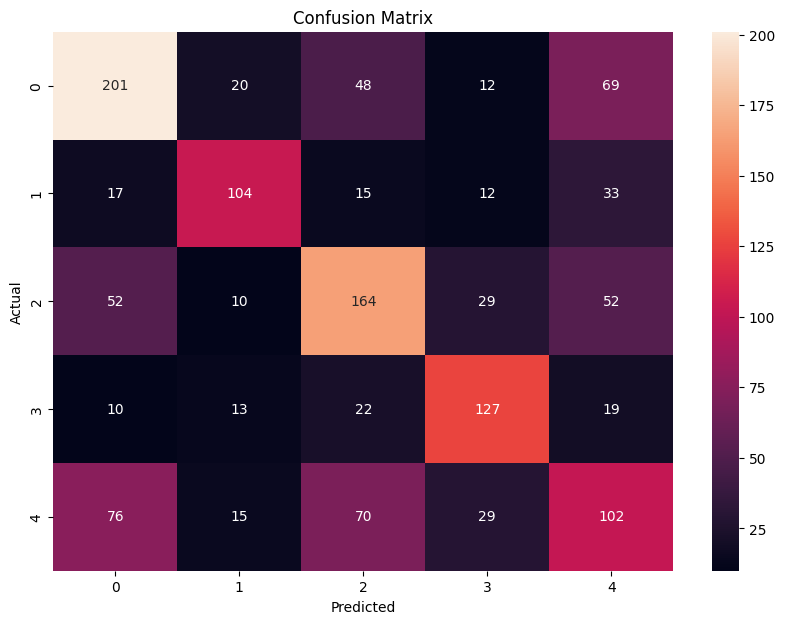

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Hitung confusion matrix
cm = confusion_matrix(Test_Y.argmax(axis=1), y_pred.argmax(axis=1))

# Buat DataFrame dari confusion matrix
cm_df = pd.DataFrame(cm, index=[i for i in range(5)], columns=[i for i in range(5)])

plt.figure(figsize=(10,7))

# Buat heatmap dari confusion matrix
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [46]:
!pip install joblib

import joblib

# Simpan model SVM dengan kernel linier dan C=1000.0
joblib.dump(model, 'lstm_model.pkl')

['lstm_model.pkl']

In [83]:
# Load the model
loaded_model = joblib.load('/content/lstm_model.pkl')
loaded_vectorizer = joblib.load("/content/bow_vectorizer.pkl")

# New sentence
new_sentence = "daywn belum makan seharian karena kipknya tidak di terima"

# Preprocess the new sentence
preprocessed_sentence = preprocess(new_sentence)

# Convert the preprocessed sentence to features
features = loaded_vectorizer.transform([preprocessed_sentence])

# Predict the sentiment
predicted_sentiment = loaded_model.predict(features)

# Print the predicted sentiment
if predicted_sentiment[0] == 0:
    print("Sentimen: negatif")
elif predicted_sentiment[0] == 1:
    print("Sentimen: positif")
else :
  print("Sentimen: netral")


1/1 [==============================] - 4s 4s/step
Sentimen: netral


# test model dengan dataset scraping

In [62]:
file_loc = "https://raw.githubusercontent.com/rizkyyanuark/College/main/datamining/combined.csv"
data_scrape = pd.read_csv(file_loc)
data_scrape

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1785300561094644037,Tue Apr 30 13:29:57 +0000 2024,0,selain kasus salah sasaran kipk ada jg yg dise...,1785300561094644037,NaN,NaN,in,NaN,0,0,0,https://twitter.com/jiegree/status/17853005610...,1344526407938916357,jiegree
1,1785300394010452166,Tue Apr 30 13:29:17 +0000 2024,0,Makin banyak yang ke spill yang kipk tapi tern...,1785300394010452166,NaN,NaN,in,Johnny,0,0,0,https://twitter.com/whosrahmah/status/17853003...,1187581909267701761,whosrahmah
2,1785253406166393056,Tue Apr 30 13:26:44 +0000 2024,0,@personality404_ the thing isss apakah that in...,1785299751065485367,NaN,personality404_,in,NaN,0,0,0,https://twitter.com/gagagagawrra/status/178529...,1662451301547118592,gagagagawrra
3,1785299607414886693,Tue Apr 30 13:26:10 +0000 2024,0,Banyak amat kipk salah sasaran inimah yg salah...,1785299607414886693,NaN,NaN,in,♡,0,0,0,https://twitter.com/samohaec/status/1785299607...,1734519974390317056,samohaec
4,1785270395622539737,Tue Apr 30 13:24:13 +0000 2024,0,@boomboomna @undipmenfess ini undip bnyk bener...,1785299116396102054,NaN,boomboomna,in,NaN,0,1,0,https://twitter.com/Nazifamulya/status/1785299...,1160811689937235968,Nazifamulya
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,1784890813501391093,Mon Apr 29 10:41:01 +0000 2024,0,@markfsoul mmf zan tapi aku bukan penerima kip...,1784895657053913391,NaN,markfsoul,in,Jakarta Selatan,0,1,0,https://twitter.com/ssenabluu/status/178489565...,2397505423,ssenabluu
4027,1328338212721311746,Mon Apr 29 10:40:46 +0000 2024,1,@digidegu Ohhh gini kelakukan penerima KIPK go...,1784895594584031590,NaN,digidegu,in,NaN,1,1,0,https://twitter.com/if_amall/status/1784895594...,1668011559547961344,if_amall
4028,1784895346692554790,Mon Apr 29 10:39:47 +0000 2024,0,Itu penerima kipk di kuliti habis2an sampe dia...,1784895346692554790,NaN,NaN,in,NaN,0,0,0,https://twitter.com/PMunceri/status/1784895346...,1784001049818505216,PMunceri
4029,1784895317474730334,Mon Apr 29 10:39:40 +0000 2024,0,Penerima kipk kan dah ada indikatornya ya... k...,1784895317474730334,NaN,NaN,in,NaN,0,1,0,https://twitter.com/ncddream/status/1784895317...,814624634498752512,ncddream


In [63]:
data_scrape = data_scrape[['created_at', 'full_text']].rename(columns={'created_at': 'date', 'full_text': 'tweet'}).drop_duplicates()
data_scrape

,date,tweet
0,Tue Apr 30 13:29:57 +0000 2024,selain kasus salah sasaran kipk ada jg yg dise...
1,Tue Apr 30 13:29:17 +0000 2024,Makin banyak yang ke spill yang kipk tapi tern...
2,Tue Apr 30 13:26:44 +0000 2024,@personality404_ the thing isss apakah that in...
3,Tue Apr 30 13:26:10 +0000 2024,Banyak amat kipk salah sasaran inimah yg salah...
4,Tue Apr 30 13:24:13 +0000 2024,@boomboomna @undipmenfess ini undip bnyk bener...
...,...,...
4026,Mon Apr 29 10:41:01 +0000 2024,@markfsoul mmf zan tapi aku bukan penerima kip...
4027,Mon Apr 29 10:40:46 +0000 2024,@digidegu Ohhh gini kelakukan penerima KIPK go...
4028,Mon Apr 29 10:39:47 +0000 2024,Itu penerima kipk di kuliti habis2an sampe dia...
4029,Mon Apr 29 10:39:40 +0000 2024,Penerima kipk kan dah ada indikatornya ya... k...


In [65]:
jumlah_tweet = data_scrape["tweet"].count()
print(f"Jumlah tweet: {jumlah_tweet}")
jumlah_nan = data_scrape.isnull().sum().sum()
print(f"Jumlah data NaN: {jumlah_nan}")

Jumlah tweet: 3938
Jumlah data NaN: 0


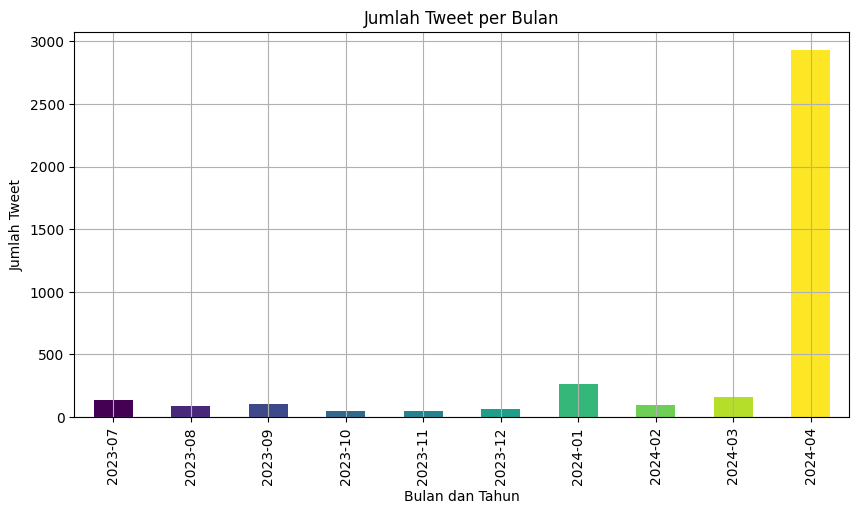

In [67]:
tweets = data_scrape.copy()
tweets['date'] = pd.to_datetime(tweets['date'], format='%a %b %d %H:%M:%S +0000 %Y')
tweets['YearMonth'] = tweets['date'].dt.to_period('M')
monthly_tweets = tweets.groupby('YearMonth').size()
colors = plt.cm.viridis(np.linspace(0, 1, len(monthly_tweets)))
monthly_tweets.plot(kind='bar', figsize=(10, 5), color=colors)
plt.xlabel("Bulan dan Tahun")
plt.ylabel("Jumlah Tweet")
plt.title("Jumlah Tweet per Bulan")
plt.grid(True)
plt.show()
data_scrape = data_scrape[['tweet']]

In [72]:
def lowercase(text):
    return text.lower()
data_scrape["cleaning"] = data_scrape.tweet.apply(lambda text: lowercase(text))
data_scrape.head(3)

In [73]:
def remove_unnecessary_char(text):
    text = re.sub('\n', ' ', text) # Remove every newline character
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Remove every username
    text = re.sub('user', ' ', text) # Remove every occurrence of the word 'user'
    text = re.sub('rt', ' ', text) # Remove every retweet symbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Remove every URL
    text = re.sub('https?://t\.me/[^\s]+', ' ', text) # Remove every Telegram link
    text = re.sub ('[^0-9a-zA-Z]+', ' ', text) # Remove every non-alphanumeric character
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
data_scrape["cleaning"] = data_scrape.cleaning.apply(lambda text: remove_unnecessary_char(text))
data_scrape.head(3)

In [74]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Text preprocessing functions from previous script
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text
def transform_emoticons(text):
    text = text.replace("<3", "<love>")
    text = text.replace(":p", "<mengejek>")
    text = text.replace(":P", "<mengejek>")
    text = text.replace(":v", "<melucu>")
    text = text.replace(":V", "<melucu>")
    text = text.replace(":d", "<tertawa>")
    text = text.replace(":D", "<tertawa>")
    text = text.replace(":-D", "<tertawa>")
    text = text.replace(":o", "<terkejut>")
    text = text.replace(":O", "<terkejut>")
    text = text.replace("xD", "<tertawa terbahak bahak>")
    text = text.replace("XD", "<tertawa terbahak bahak>")
    text = text.replace(":*", "<mencium>")
    text = text.replace(":3", "<malu malu kucing>")
    text = text.replace("-__-", "<wajah datar>")
    text = text.replace("-_-", "<wajah datar>")
    text = text.replace(":|", "<wajah datar>")
    text = text.replace(":\\", "<terganggu>")
    text = text.replace(":/", "<terganggu>")
    text = text.replace(":))", "<senyum>")
    text = text.replace(":)", "<senyum>")
    text = text.replace(":-))", "<senyum>")
    text = text.replace(":-)", "<senyum>")
    text = text.replace("^^", "<senyum>")
    text = text.replace("^_^", "<senyum>")
    text = text.replace(";))", "<senyum berkedip>")
    text = text.replace(";)", "<senyum berkedip>")
    text = text.replace(":((", "<sedih>")
    text = text.replace(":(", "<sedih>")
    text = text.replace(":-((", "<sedih>")
    text = text.replace(":-(", "<sedih>")
    text = text.replace(":'((", "<menangis sedih>")
    text = text.replace(":'(", "<menangis sedih>")
    text = text.replace(":'))", "<menangis bahagia>")
    text = text.replace(":')", "<menangis bahagia>")
    text = text.replace(":'", "<menangis sedih>")
    text = text.replace(":’((", "<menangis sedih>")
    text = text.replace(":’(", "<menangis sedih>")
    text = text.replace(":’))", "<menangis bahagia>")
    text = text.replace(":’)", "<menangis bahagia>")
    text = text.replace(":’", "<menangis sedih>")
    text = text.replace(":\"((", "<menangis sedih>")
    text = text.replace(":\"(", "<menangis sedih>")
    text = text.replace(":\"))", "<menangis bahagia>")
    text = text.replace(":\")", "<menangis bahagia>")
    text = text.replace(":\"", "<menangis sedih>")
    text = text.replace(":\"D", "<menangis bahagia>")
    text = text.replace("TT", "<menangis sedih>")
    return text

def normalize_alay(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

def normalize_singkatan(text):
    return ' '.join([kamus_singkatan_map[word] if word in kamus_singkatan_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join([ ' ' if word in stopword_bahasa.ada.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  return d_clean

# Modified clean_text function that calls preprocessing functions from previous script
def preprocess(text):
    text = normalize_alay(text) # Normalize text using alay_dict_map
    text = normalize_singkatan(text) # Normalize text using alay_dict_map2
    text = remove_stopword(text) # Remove stopwords from text
    text = tokenizingText(text)
    text = stemming(text)
    return text
data_scrape['preprocessing'] = data_scrape['cleaning'].apply(preprocess)
data_scrape

In [79]:
# Load the model
loaded_model = joblib.load("/content/lstm_model.pkl")

# Load your vectorizer
loaded_vectorizer = joblib.load("/content/bow_vectorizer.pkl")  # replace with your vectorizer file path

def predict_sentiment(text):
    # Convert text to features
    features = loaded_vectorizer.transform([text])
    # Predict sentiment
    predicted_sentiment = loaded_model.predict(features)
    # Determine sentiment based on prediction
    if predicted_sentiment[0] == 0:
        sentiment_result = "negatif"
    elif predicted_sentiment[0] == 1:
        sentiment_result = "positif"
    else:
        sentiment_result = "netral"  # default case
    return sentiment_result
# Apply the function to the 'preprocessing' column
data_scrape['label'] = data_scrape['preprocessing'].apply(predict_sentiment)

1/1 [==============================] - 1s 715ms/step


KeyboardInterrupt: 

In [76]:
data_scrape

,tweet,cleaning,preprocessing,label
0,selain kasus salah sasaran kipk ada jg yg dise...,selain kasus salah sasaran kipk ada jg yg dise...,salah sasar kipk ada program keluarga harap pa...,None
1,Makin banyak yang ke spill yang kipk tapi tern...,makin banyak yang ke spill yang kipk tapi tern...,spill kipk hidup boros alias salah sasar kasih...,None
2,@personality404_ the thing isss apakah that in...,the thing isss apakah that influencer mau diw...,the thing isss that influencer wawancara kipk ...,None
3,Banyak amat kipk salah sasaran inimah yg salah...,banyak amat kipk salah sasaran inimah yg salah...,kipk salah sasar inimah salah seleksi kipk nya...,None
4,@boomboomna @undipmenfess ini undip bnyk bener...,ini undip bnyk bener ee kejadian kipk salah s...,undip tahi jadi kipk salah sasar,None
...,...,...,...,...
4026,@markfsoul mmf zan tapi aku bukan penerima kip...,mmf zan tapi aku bukan penerima kipk ukt 8jt ...,mmf zan terima kipk ukt 8jt ter seok seok,None
4027,@digidegu Ohhh gini kelakukan penerima KIPK go...,ohhh gini kelakukan penerima kipk goblok pemb...,ohhh laku terima kipk goblok pembokep,None
4028,Itu penerima kipk di kuliti habis2an sampe dia...,itu penerima kipk di kuliti habis2an sampe dia...,terima kipk kulit habis2an rep base friends wi...,None
4029,Penerima kipk kan dah ada indikatornya ya... k...,penerima kipk kan dah ada indikatornya ya kalo...,terima kipk ada indikator ya rasa anak sesuai ...,None
